In [1]:
import librosa, librosa.display
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt 
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# 「MIR-02_3」音频特征小全之频域特征

> 频域特征(spectral feature)是将音频波形变换到频域之后得出的一系列基于频谱的指标。

**♬ 本文为MIR音乐信息检索系列的第2.3篇文章 ♬**

**♬ 该文与2.1概览+2.2时域特征及后续2.X文章共同组成音频特征小全 ♬**

本文将主要讲解以下频域特征及其简单应用：
- 为什么用频谱质心高不高来乐器声音听上去亮不亮？
- 如何用频谱差分幅度得出一个个乐音开始演奏的时刻？
- 大名鼎鼎的MFCC到底是什么？

---

### 『回顾音色』

前文2.2提到时域包络的差异是帮助我们理解“不同乐器有不同音色”的助手之一，其他助手集中在频域。这个不是我瞎说的，而是早在90年代左右就有心理声学学者给志愿者们听许多对儿乐器声音，并让他们给这一对对声音在音色上的不相似程度打分，最后用数学建模估计出大致可以用多少个维度来共同表示出人们如何区分不同音色，实验过程如下图：

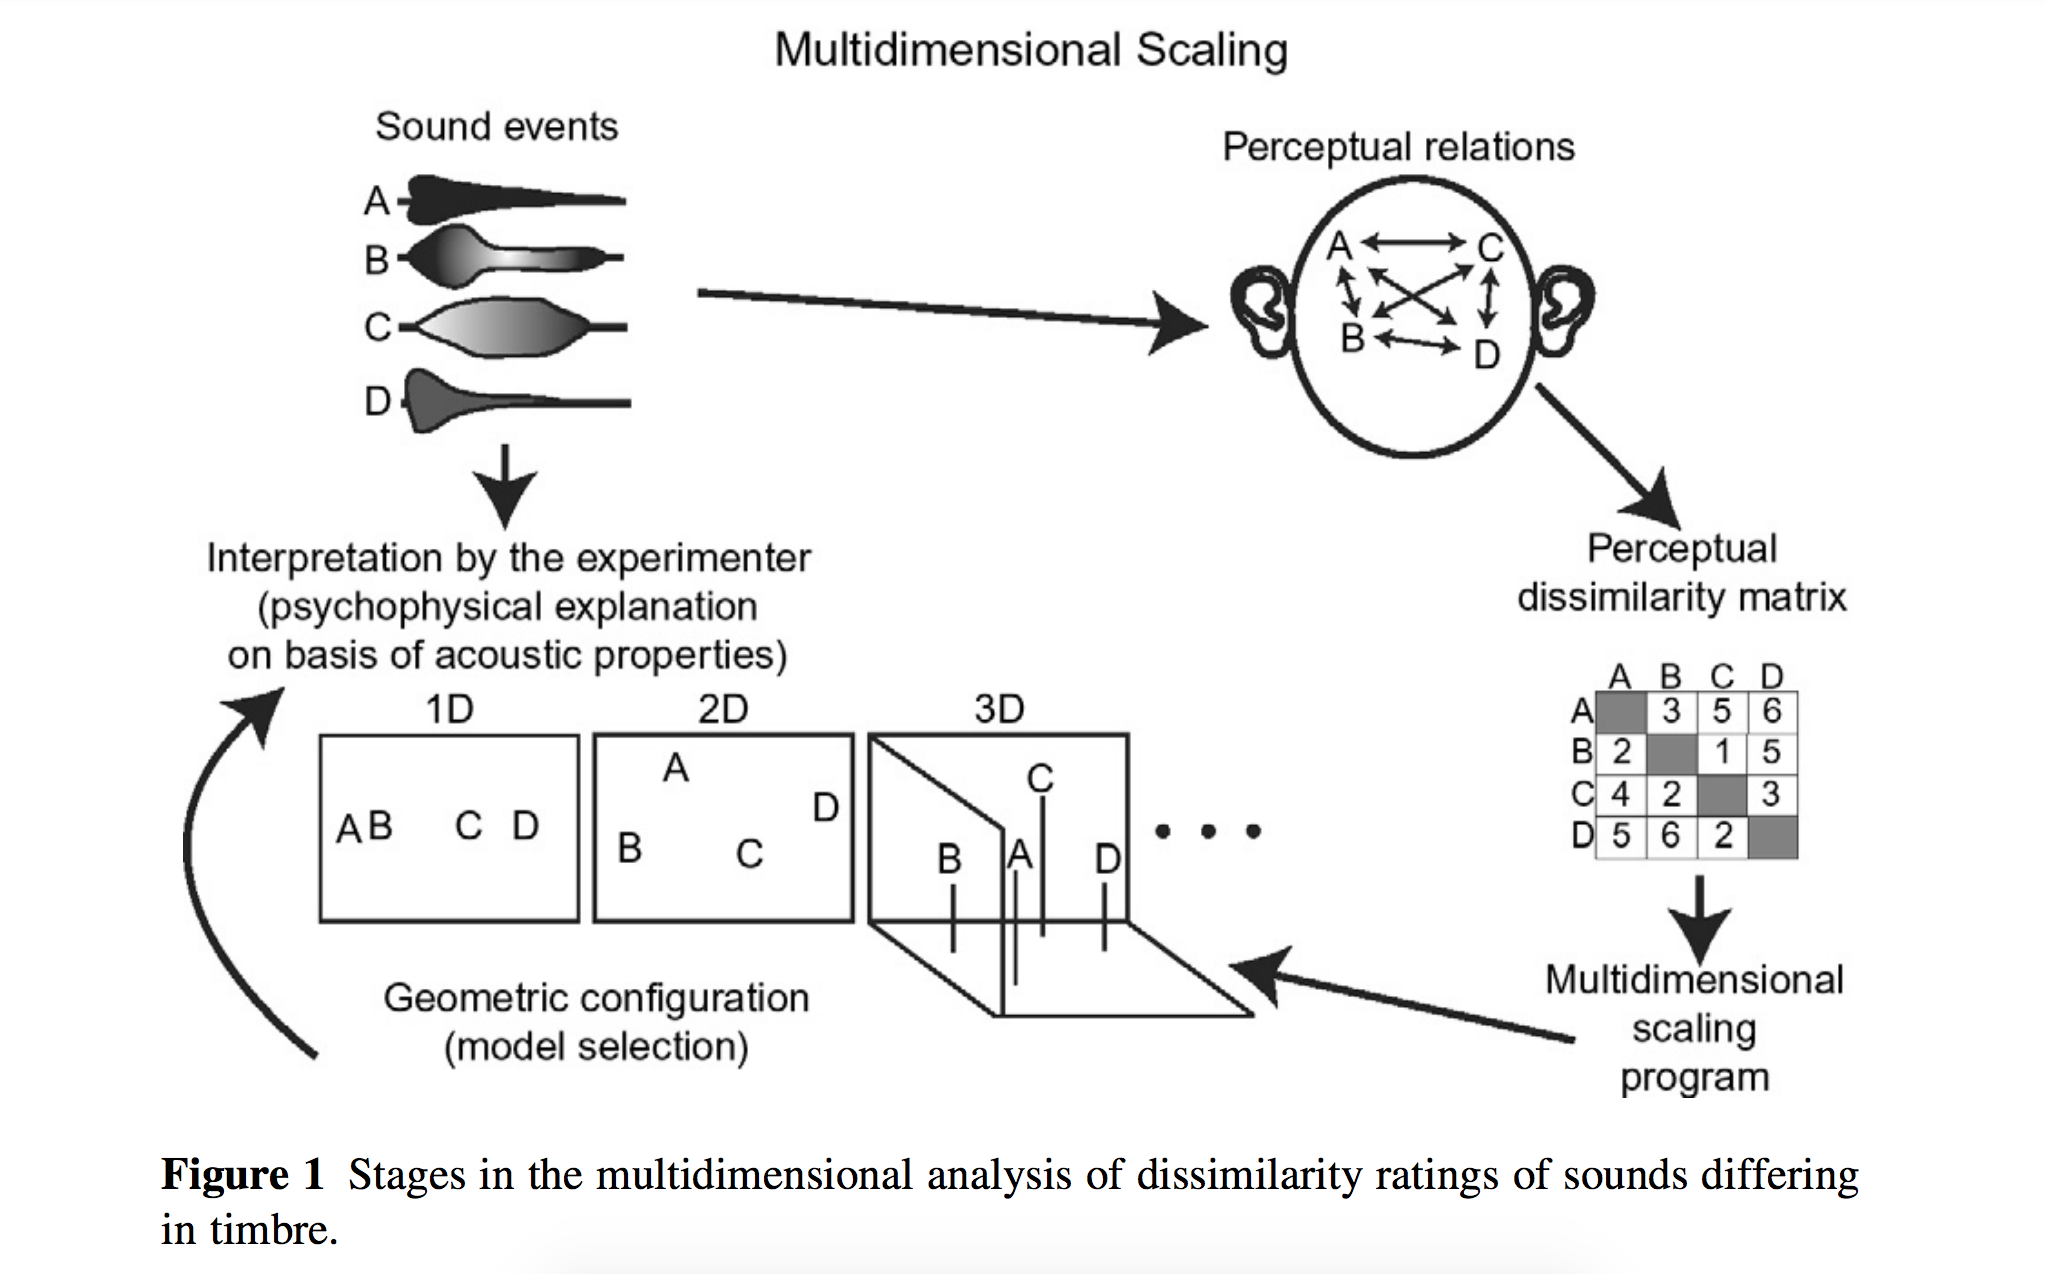

In [2]:
ipd.Image("attachment/mir02-mds.png")

✎ McAdam在1995年发表的论文中指出，可以用以下3个维度来表示音色空间：起音的时间（详见上文2.2），频谱质心，频谱差分幅度。后两者就是本文频域特征的两大主角儿。

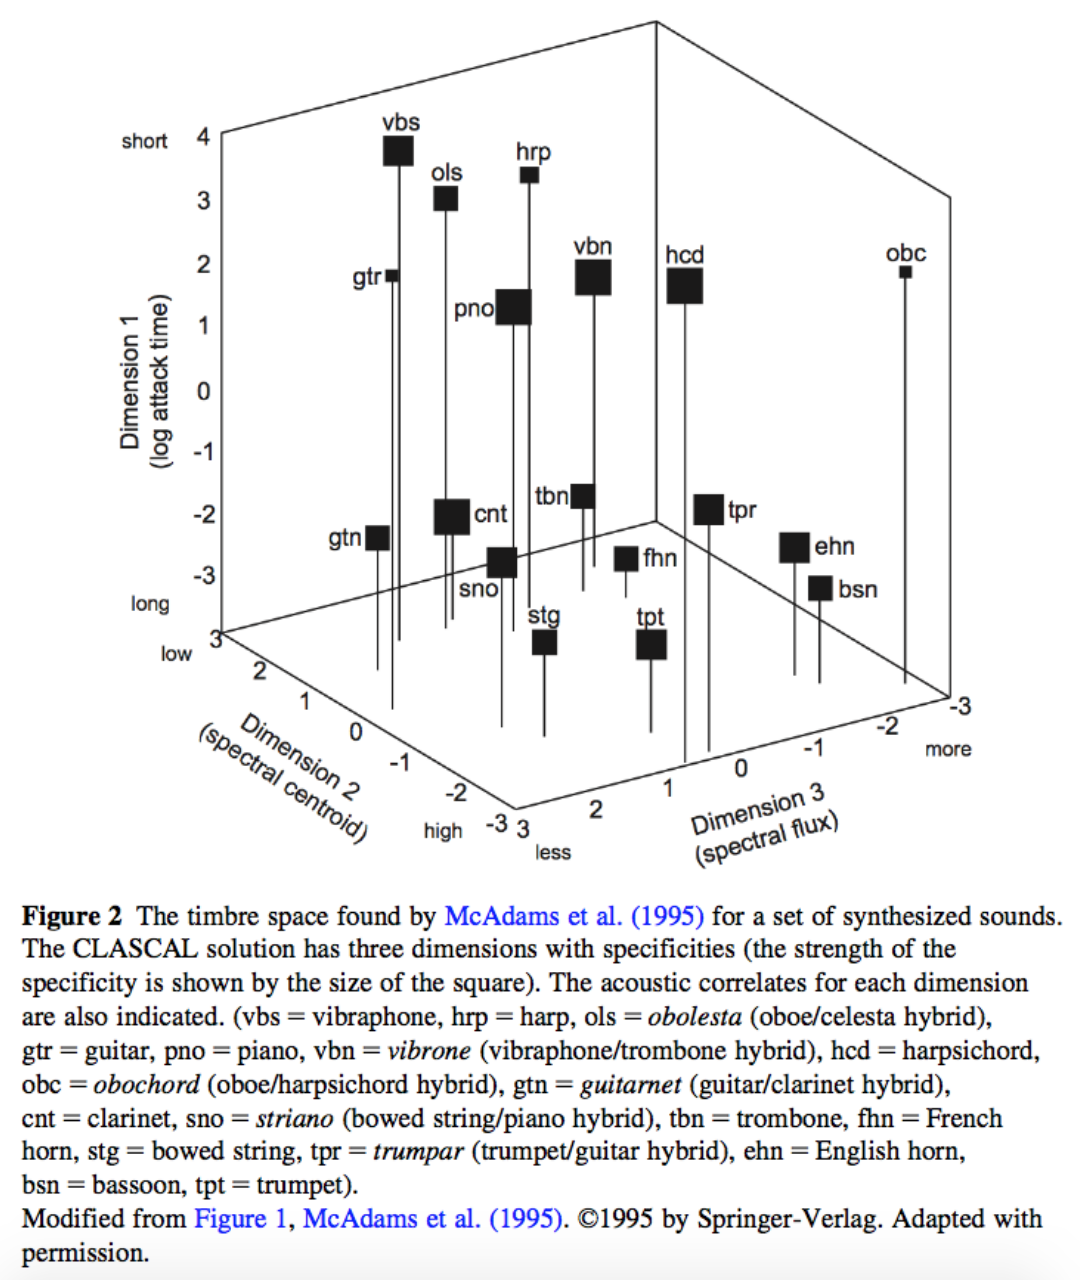

In [3]:
ipd.Image("attachment/mir02-timbrespace.png")


---

### 『频谱质心』

频谱质心(spectral centroid)可表示频谱$X$中的能量大致平均集中在哪个频率附近，数学计算公式为：

$$c_s = \frac{\sum_k f(k)|X(k)|}{\sum_k |X(k)|}$$

其中$|X(k)|$指频谱在第$k$个频点上的幅度值， $f(k)$则为第$k$个频点对应的频率值，

即使是同样音高的音符，不同乐器每个音上泛音能量的分布不一样，则各个音在“听上去相对明亮的乐器”中大部分能量分布在频率较高的区域，那么频谱质心的值当然就更高。我们用下方音频为例，可看到演奏同音高的音符时，钢琴vs羽管键琴在频谱质心上数值的变化。

In [4]:
audio, sr = librosa.load('attachment/mir02-centroidaudio.wav')
ipd.Audio(audio, rate=sr)

我们可以直接调用librosa中计算频谱质心的方法，画出它随着音乐波形和STFT频谱的变化，可见在5.5秒左右羽管键琴开始演奏时，数值跟之前的钢琴音频相比有明显升高。代码如下：

Text(0.5,1,'STFT spectrogram & Spectral Centroid')

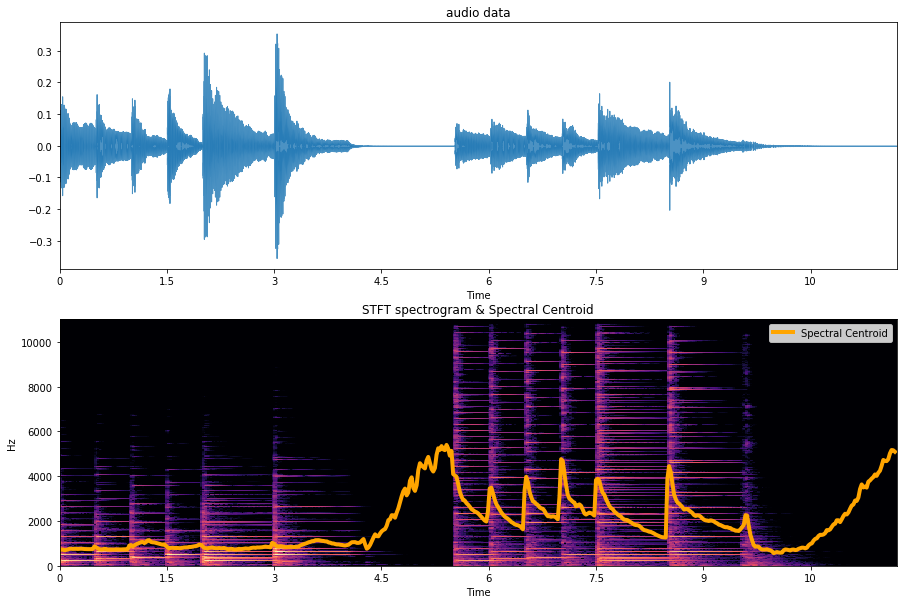

In [7]:
D = librosa.stft(audio, n_fft=2048, hop_length=512)
magnitude, phase = librosa.magphase(D)
cent = librosa.feature.spectral_centroid(y=audio, sr=sr)

plt.figure(figsize=(15,10))
# 画出音频数据在时域上的波形图
ax1 = plt.subplot(2,1,1)
librosa.display.waveplot(audio, sr, alpha=0.8)
plt.title('audio data')
# 画出STFT后的功率谱（以dB为单位）以及频谱质心随时间的变化
ax2 = plt.subplot(2,1,2, sharex=ax1)
librosa.display.specshow(librosa.amplitude_to_db(magnitude, ref=np.max), sr=sr, y_axis='linear', x_axis='time')
cent_times = librosa.frames_to_time(np.arange(len(cent[0])), sr=sr, hop_length=512)
plt.plot(cent_times, cent[0], label='Spectral Centroid', lw=4, color='orange')
plt.legend()
plt.title('STFT spectrogram & Spectral Centroid')

---

### 『频谱差分幅度』

频谱差分幅度(spectral flux)可以表示音频频谱中的功率变化的有多快，因此在公式上计算的是相邻两帧之间谱的变化量。但在具体计算这个“变化量”时，目前有几种经典的算法，可以主要参考以下两篇论文：

☞ [Dixon, Simon. "Onset detection revisited." Proceedings of the 9th International Conference on Digital Audio Effects. pp.133–137. 2006.](https://www.eecs.qmul.ac.uk/~simond/pub/2006/dafx.pdf)

☞ [Böck, Sebastian, and Gerhard Widmer. "Maximum filter vibrato suppression for onset detection." Proceedings of the 16th International Conference on Digital Audio Effects. 2013.](http://dafx13.nuim.ie/papers/09.dafx2013_submission_12.pdf)

之所以能用频谱差分幅度作为检测音符弹奏时刻(onset)的方法，就是利用新的音符在弹奏时带来的频谱能量上的突变，这种突变也许在RMS能量上不那么明显，因此凸显出频谱差分幅度的优越性。然而它的弱点在于如何抵制颤音技巧带来的影响，这也是为什么上方第二个文献会提出的一种super flux的方法。

✎ 我们继续用上方音频画出它的频谱差分幅度随时间的变化：

Text(0.5,1,'Spectral Flux & Detected Onset')

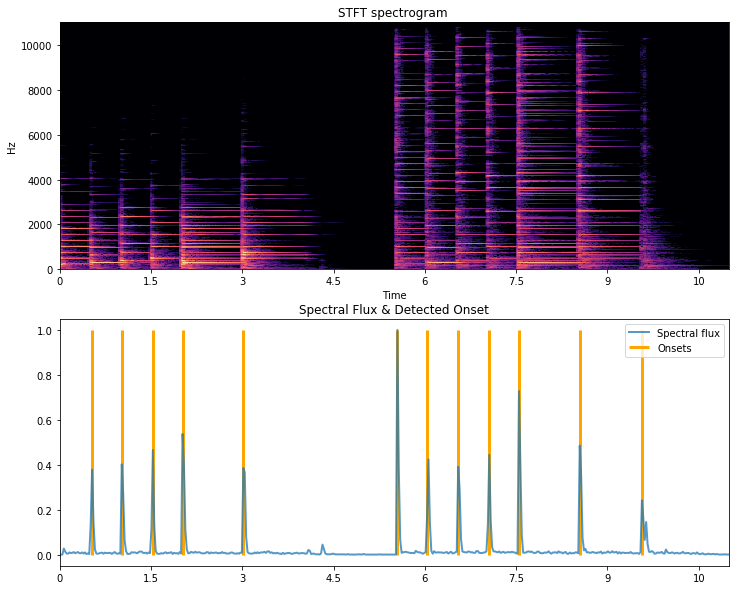

In [16]:
spectral_flux = librosa.onset.onset_strength(y=audio, sr=sr, hop_length=512)
spectral_flux_times = librosa.frames_to_time(np.arange(len(spectral_flux)), sr=sr, hop_length=512)

onset_times = librosa.onset.onset_detect(onset_envelope=spectral_flux, sr=sr, hop_length=512, units='time')

plt.figure(figsize=(12,10))
# 画出STFT功率谱（以dB为单位）
ax1 = plt.subplot(2,1,1)
librosa.display.specshow(librosa.amplitude_to_db(magnitude, ref=np.max), sr=sr, y_axis='linear', x_axis='time')
plt.xlim([0, 11])
plt.title('STFT spectrogram ')
# 画出频谱差分幅度，以及基于其被检测出的onset
ax2 = plt.subplot(2,1,2, sharex=ax1)
plt.plot(spectral_flux_times, spectral_flux, lw=2, alpha=0.75, label='Spectral flux')
plt.vlines(onset_times, 0, spectral_flux.max(), label='Onsets', lw=3, color='orange')
plt.xlim([0, 11])
plt.legend()
plt.title('Spectral Flux & Detected Onset')

✎ 上方在计算出spectral flux之后，可利用峰值检测(peak picking)的方法得出onset到底发生在那个时刻。

---

### 『梅尔倒谱系数MFCC』

梅尔倒谱系数（Mel Frequency Cepstral Coefficients，简称MFCC）在80年代被Davis和Mermelstein提出之后，就在语音识别/话者识别的任务中挑大梁挑了好多年。相比于用$F(频点数量) * T(帧数)$表示一段音频，尤其是$F$可能高达成千上万，使用MFCC就能有效降维到$MFCCs * T$。这里的“有效”就在于MFCC能用几个系数表示每个帧内最有用的信息，而系数得出的过程又和人耳对声音频率以及响度的认知息息相关，可以说是一个非常美丽的算法了。尽量略过数学计算，可以将计算过程表示为以下6步骤：

第1步：参照STFT的第1步，我们需要将音频分成连续的一帧帧；

第2步：在每一帧里用DFT（或者其加速版-FFT）得出功率谱；

第3步：在每一帧里的功率谱都加上Mel尺度的三角形滤波器组（就像下图filterbank一样），在每个滤波器覆盖的范围下计算出其涵盖的能量值；

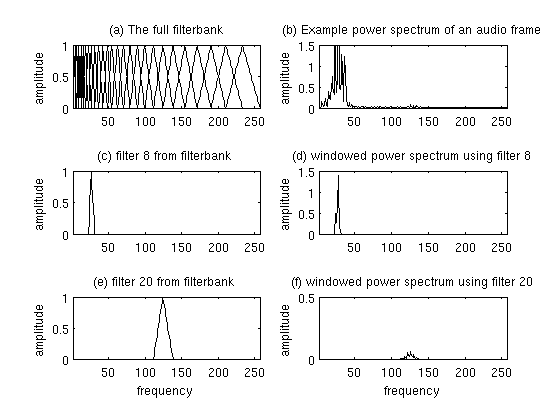

In [18]:
ipd.Image("attachment/mir02-melfilterbank.png")

那么问题来了，为什么要加Mel尺度而非线性的？因为人耳本身的感知能力有限，在低频区域也许能分清50Hz和60Hz的区别，但同样差10个Hz,分清1050与1060Hz就没那么容易了，再往上走，4000Hz变成5000Hz，也许你觉得就高了几十个Hz而已。总而言之，人耳在感受客观上线性递增的频率时，其实是主观理解成$m_freq=2595\log_{10}(1+f/700)$这样的。因此如上方小图(a)中，高的频段里就没必要还用那么“窄”的滤波器去提取信息了，反正窄的宽的你也听不出来，不如用宽点的滤波器来节省一些计算。

第4步：对每一帧里的每个滤波器下得出的能量，取！对！数！为什么？因为人耳不仅对频率变得越来越高没那么敏感，音量变得越来越大也感受没那么大，人家客观能量也许提高了足足八倍，你才在主观上能大致感受到“诶这个音量好像提高了一倍哦？”

第5步：最后，对每一帧下的Mel频谱对数能量谱做离散余弦变换（DCT）得到表示该谱包络形状的系数们，只保留前几个主要的系数即是我们需要的MFCC了！

✎ 在代码部分依然可以直接用librosa提取，还是用之前的音频，在其每一帧下提取20个MFCC的话：

Text(0.5,1,'MFCC')

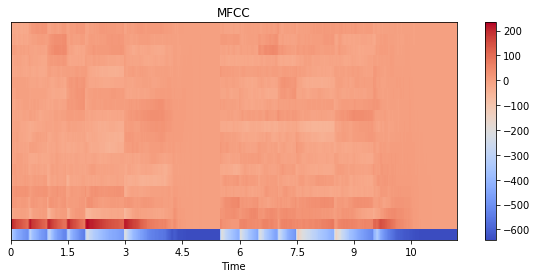

In [19]:
mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')

✎ 肉眼可见钢琴和羽管键琴在MFCC上的区别还是存在的，比如上图最下方第二排对应的数值中，钢琴就比羽管键琴更“红”。抓住MFCC中的区别，既然能实现话者识别，那么也能做出乐器识别。

☞ 更多MFCC计算细节可参照[CMU语音课的幻灯片](http://www.speech.cs.cmu.edu/15-492/slides/03_mfcc.pdf)

---

以上提出的频域特征一般不随音乐的音高发生改变，如果你想识别出一段音频中的旋律是怎样的，请期待下节「MIR-02_4」乐音特征(harmonic feature)!